## Step 1: Import the modules

In [140]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Step 2: read the data

In [141]:
from sklearn.datasets import fetch_openml
credit_data = fetch_openml("credit-g", as_frame=True)
df = credit_data.frame
print(df.head())

  checking_status  duration                  credit_history  \
0              <0         6  critical/other existing credit   
1        0<=X<200        48                   existing paid   
2     no checking        12  critical/other existing credit   
3              <0        42                   existing paid   
4              <0        24              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv           1169  no known savings        >=7   
1             radio/tv           5951              <100     1<=X<4   
2            education           2096              <100     4<=X<7   
3  furniture/equipment           7882              <100     4<=X<7   
4              new car           4870              <100     1<=X<4   

   installment_commitment     personal_status other_parties  ...  \
0                       4         male single          none  ...   
1                       2  female div/dep/mar          none  ...

In [142]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


## Step 3: Check for the missing values and remove them

In [143]:
df = df.dropna()

# Check for and fill missing values:
df = df.fillna(df.mean(numeric_only=True))

# Drop duplicate columns
df = df.loc[:, ~df.T.duplicated()]

# Drop constant value columns
df = df.loc[:, df.nunique() > 1]

df.shape
##there were no missing values; the shape of the df remains the same

(1000, 21)

## Step 4: EDA

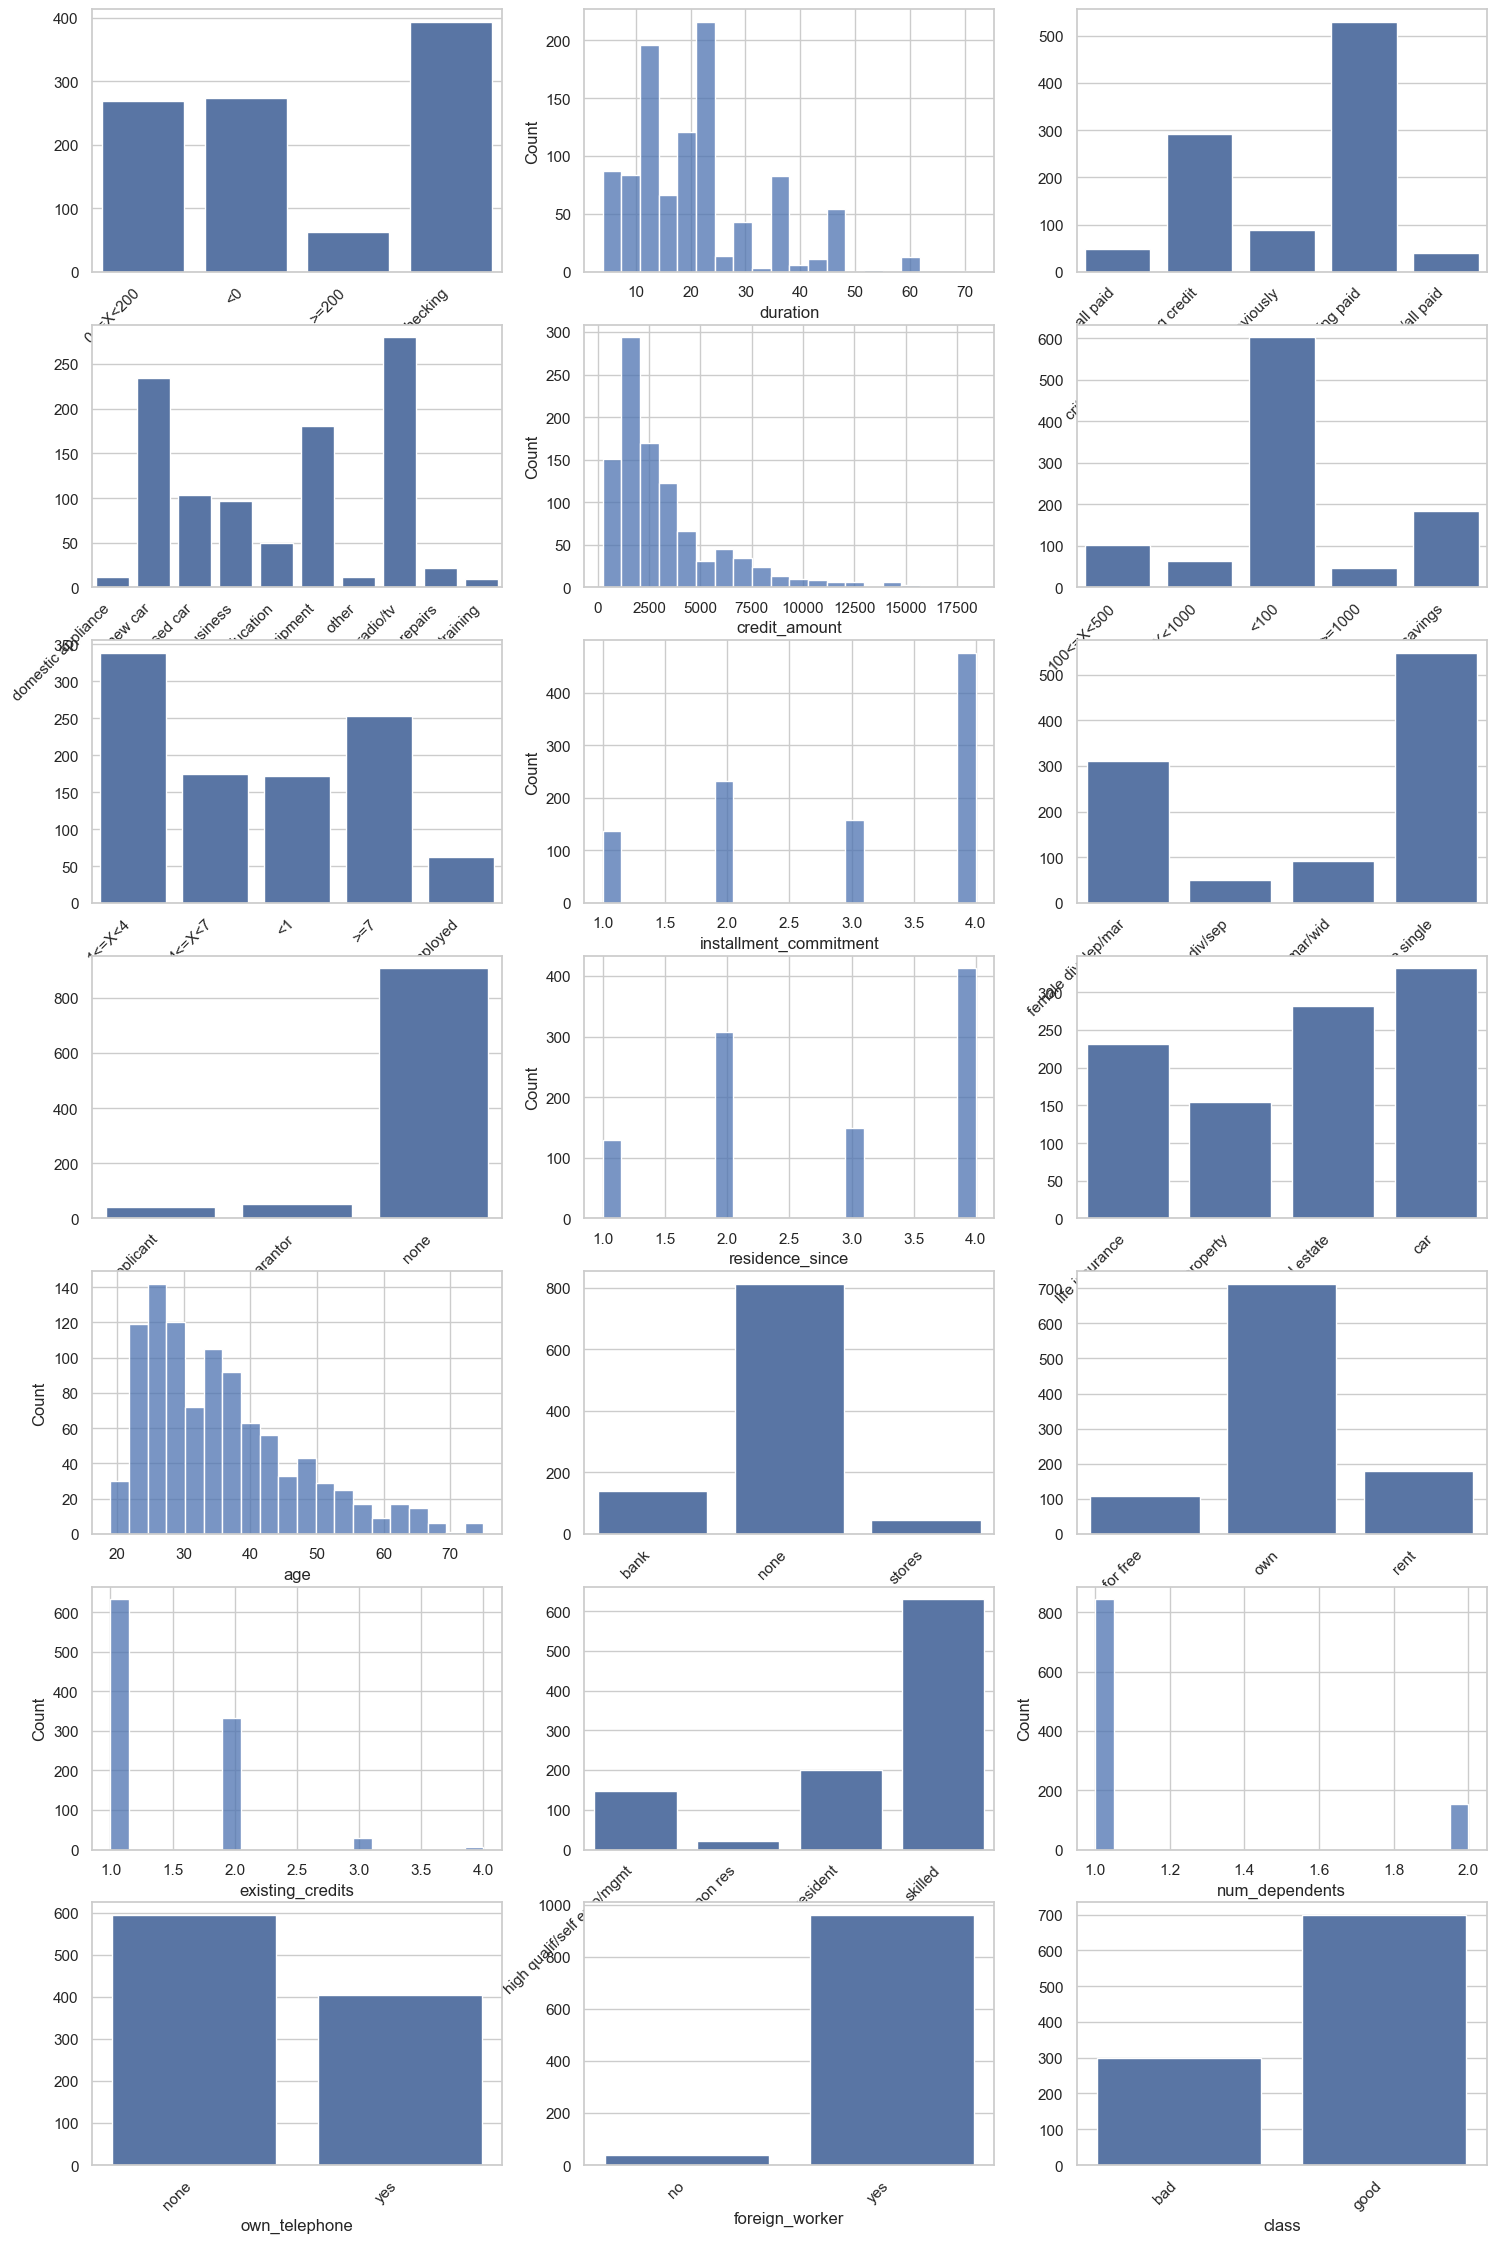

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Set up the figure
n_cols = 3
n_rows = math.ceil(len(df.columns) / n_cols)
plt.figure(figsize=(18, 4*n_rows))

# Plot each column
for i, column in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i+1)
    
    if df[column].dtype in ['object', 'category']:
        # Categorical: Count plot (top 10 categories if too many)
        top_categories = df[column].value_counts().nlargest(10)
        sns.barplot(x=top_categories.index, y=top_categories.values)
        plt.xticks(rotation=45, ha='right')
    else:
        # Numerical: Histogram (auto-binned)
        sns.histplot(df[column], kde=False, bins=20)
        
plt.show()

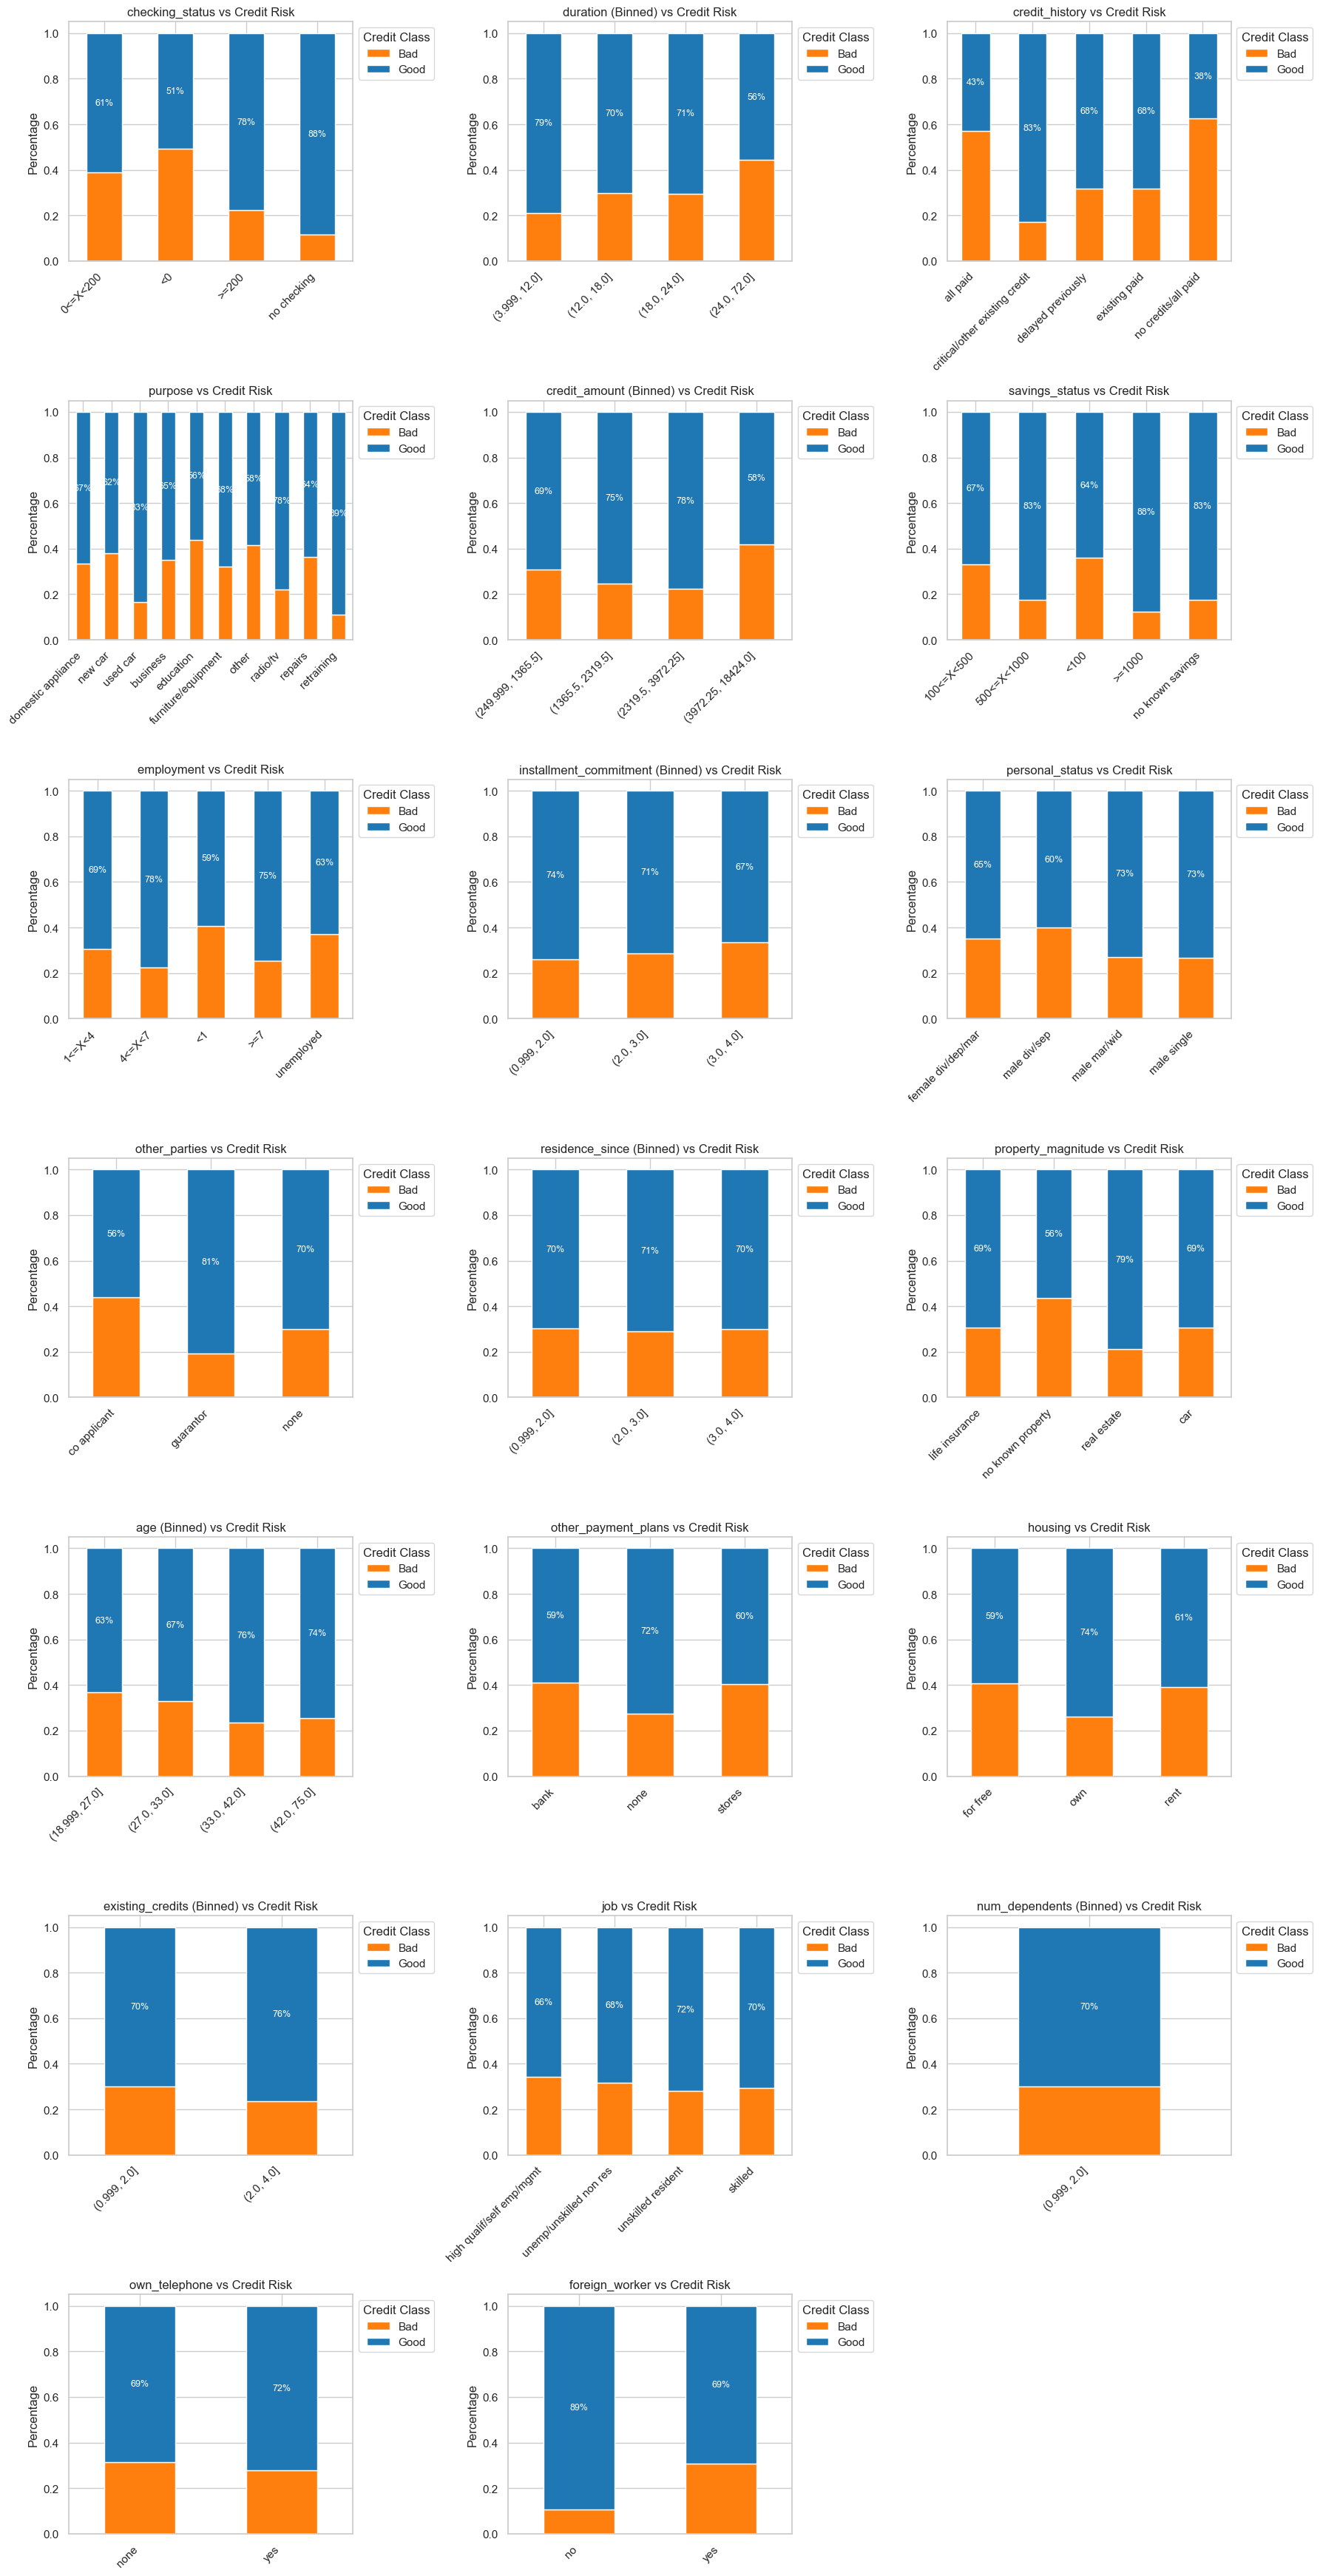

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# 1. Prepare plotting data for any column type
def prepare_plot_data(df, col, target='class'):
    if df[col].dtype in ['object', 'category']:
        # Categorical: Direct crosstab
        return pd.crosstab(df[col], df[target], normalize='index')
    else:
        # Numerical: Bin into quartiles first
        binned = pd.qcut(df[col], q=4, duplicates='drop')
        return pd.crosstab(binned, df[target], normalize='index')

# 2. Get all columns (excluding target)
all_cols = [col for col in df.columns if col != 'class']

# 3. Set up visualization
n_cols = 3
n_rows = math.ceil(len(all_cols) / n_cols)
plt.figure(figsize=(18, 5*n_rows))

for i, col in enumerate(all_cols):
    plt.subplot(n_rows, n_cols, i+1)
    
    # Prepare data
    plot_data = prepare_plot_data(df, col)
    
    # Plot stacked bars
    plot_data.plot(kind='bar', stacked=True, ax=plt.gca(), 
                 color=['#ff7f0e', '#1f77b4'])  # Orange/blue for bad/good
    
    # Formatting
    dtype_label = '' if df[col].dtype in ['object', 'category'] else ' (Binned)'
    plt.title(f'{col}{dtype_label} vs Credit Risk')
    plt.ylabel('Percentage')
    plt.xlabel('')
    plt.xticks(rotation=45, ha='right')
    
    # Improve legend
    plt.legend(title='Credit Class', bbox_to_anchor=(1, 1), 
              labels=['Bad', 'Good'])
    
    # Add value labels for top segment
    for bar in plt.gca().patches[len(plot_data):]:  # Just the 'good' segments
        width = bar.get_width()
        height = bar.get_height()
        x = bar.get_x()
        y = bar.get_y()
        if height > 0.1:  # Only label significant segments
            plt.gca().text(x + width/2, y + height/2, 
                         f'{height:.0%}', 
                         ha='center', va='center',
                         color='white', fontsize=9)

plt.tight_layout()
plt.show()

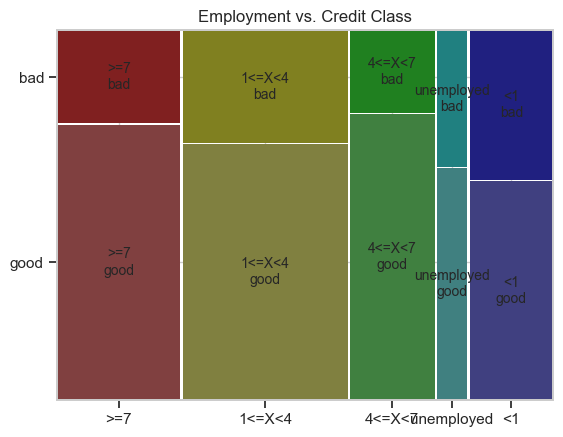

In [146]:
from statsmodels.graphics.mosaicplot import mosaic

# Compare two categorical variables
mosaic(df, ['employment', 'class'], title='Employment vs. Credit Class')
plt.show()

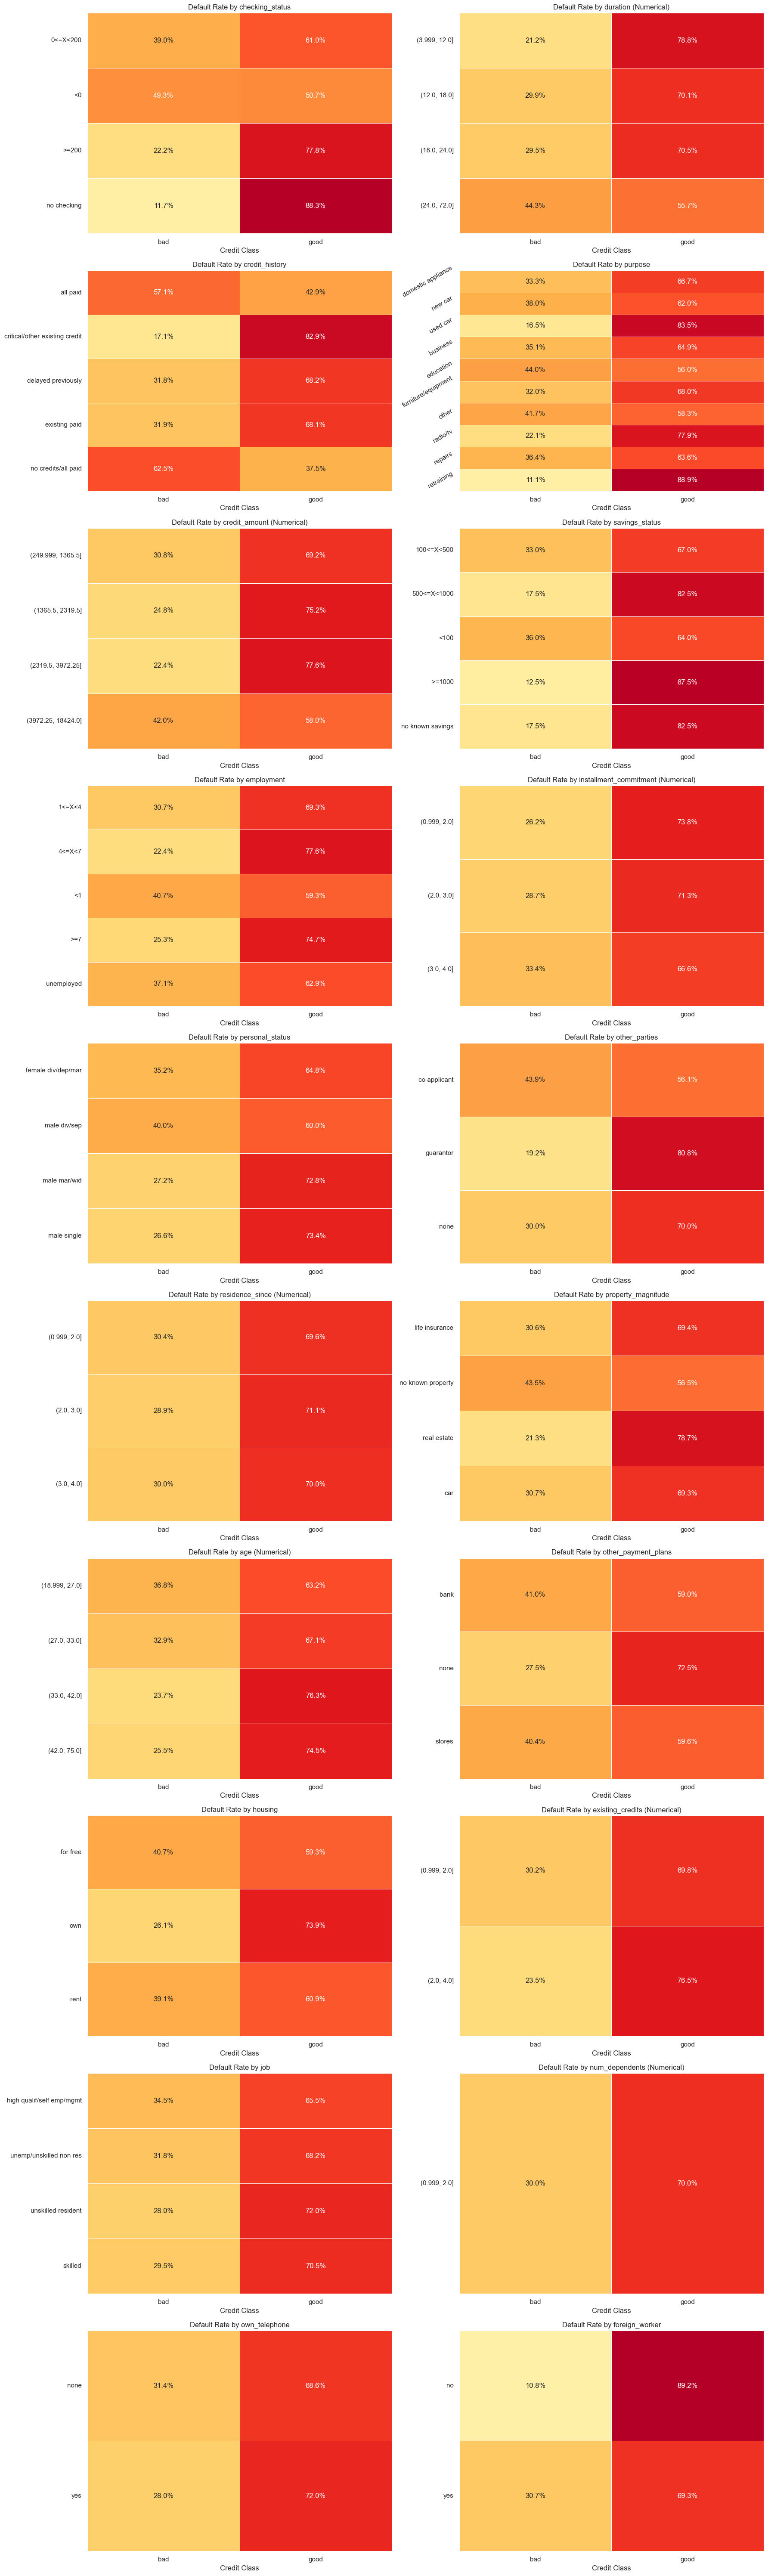

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# 1. Prepare the data
def prepare_heatmap_data(df, col, target='class'):
    if df[col].dtype in ['object', 'category']:
        # Categorical: Crosstab with percentages
        return pd.crosstab(df[col], df[target], normalize='index')
    else:
        # Numerical: Bin into quartiles then crosstab
        binned = pd.qcut(df[col], q=4, duplicates='drop')
        return pd.crosstab(binned, df[target], normalize='index')

# 2. Get all columns (excluding target)
all_cols = [col for col in df.columns if col != 'class']

# 3. Set up visualization
n_cols = 2
n_rows = math.ceil(len(all_cols) / n_cols)
plt.figure(figsize=(18, 6*n_rows))

for i, col in enumerate(all_cols):
    plt.subplot(n_rows, n_cols, i+1)
    
    # Create heatmap data
    heatmap_data = prepare_heatmap_data(df, col)
    
    # Plot heatmap
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='.1%',
        cmap='YlOrRd',
        vmin=0,
        vmax=1,
        cbar=False,
        linewidths=0.5
    )
    
    # Formatting
    dtype = ' (Numerical)' if df[col].dtype in ['int64', 'float64'] else ''
    plt.title(f'Default Rate by {col}{dtype}')
    plt.ylabel('')
    plt.xlabel('Credit Class')
    
    # Adjust label rotation
    if len(heatmap_data) > 5:
        plt.yticks(rotation=30)
    else:
        plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

## Step 5: Feature selection

In [148]:
#columns to remove
cols_to_drop=['checking_status', 'other_payment_plans', 'own_telephone', 'foreign_worker', 'purpose', 'residence_since', 'other_payment_plans', 'property_magnitude']
df.drop(columns=cols_to_drop, inplace=True)
df

,duration,credit_history,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,age,housing,existing_credits,job,num_dependents,class
0,6,critical/other existing credit,1169,no known savings,>=7,4,male single,none,67,own,2,skilled,1,good
1,48,existing paid,5951,<100,1<=X<4,2,female div/dep/mar,none,22,own,1,skilled,1,bad
2,12,critical/other existing credit,2096,<100,4<=X<7,2,male single,none,49,own,1,unskilled resident,2,good
3,42,existing paid,7882,<100,4<=X<7,2,male single,guarantor,45,for free,1,skilled,2,good
4,24,delayed previously,4870,<100,1<=X<4,3,male single,none,53,for free,2,skilled,2,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,existing paid,1736,<100,4<=X<7,3,female div/dep/mar,none,31,own,1,unskilled resident,1,good
996,30,existing paid,3857,<100,1<=X<4,4,male div/sep,none,40,own,1,high qualif/self emp/mgmt,1,good
997,12,existing paid,804,<100,>=7,4,male single,none,38,own,1,skilled,1,good
998,45,existing paid,1845,<100,1<=X<4,4,male single,none,23,for free,1,skilled,1,bad


## Step 6: Data Preprocessing
## Prepare the dataset for machine learning
### a) Encoding

In [149]:
##Columns for ordinal encoding: credit_history, savings_status, employment, other_parties, housing, job, class
##Columns for label encoding: personal_status
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
ordinal_mappings={'credit_history':['no credits/all paid', 'all paid', 'existing paid', 'delayed previously', 'critical/other existing credit'],
                 'savings_status':['>=1000', '500<=X<1000', '100<=X<500', '<100', 'no known savings'],
                 'employment':['>=7', '1<=X<4', '4<=X<7', 'unemployed', '<1'],
                 'other_parties':['co applicant','guarantor', 'none'],
                 'housing':['for free', 'own', 'rent'],
                 'job':['high qualif/self emp/mgmt', 'skilled', 'unskilled resident', 'unemp/unskilled non res'],
                 'class':['good','bad']                   
                 }
# Ordinal Encoding (single operation)
ordinal_cols = list(ordinal_mappings.keys())
ordinal_orders = list(ordinal_mappings.values())
df[ordinal_cols] = OrdinalEncoder(categories=ordinal_orders).fit_transform(df[ordinal_cols])
# Label Encoding (for personal_status only)
df['personal_status'] = LabelEncoder().fit_transform(df['personal_status'])
df

,duration,credit_history,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,age,housing,existing_credits,job,num_dependents,class
0,6,4.0,1169,4.0,0.0,4,3,2.0,67,1.0,2,1.0,1,0.0
1,48,2.0,5951,3.0,1.0,2,0,2.0,22,1.0,1,1.0,1,1.0
2,12,4.0,2096,3.0,2.0,2,3,2.0,49,1.0,1,2.0,2,0.0
3,42,2.0,7882,3.0,2.0,2,3,1.0,45,0.0,1,1.0,2,0.0
4,24,3.0,4870,3.0,1.0,3,3,2.0,53,0.0,2,1.0,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,2.0,1736,3.0,2.0,3,0,2.0,31,1.0,1,2.0,1,0.0
996,30,2.0,3857,3.0,1.0,4,1,2.0,40,1.0,1,0.0,1,0.0
997,12,2.0,804,3.0,0.0,4,3,2.0,38,1.0,1,1.0,1,0.0
998,45,2.0,1845,3.0,1.0,4,3,2.0,23,0.0,1,1.0,1,1.0


## Step 6: Data Preprocessing
## Prepare the dataset for machine learning
### b) Scaling

In [150]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=df.drop(columns=['class'])
y = df['class']
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-1.23647786,  1.34401408, -0.74513141, ...,  1.02707891,
        -0.14694918, -0.42828957],
       [ 2.24819436, -0.50342796,  0.94981679, ..., -0.704926  ,
        -0.14694918, -0.42828957],
       [-0.73866754,  1.34401408, -0.41656241, ..., -0.704926  ,
         1.38377145,  2.33486893],
       ...,
       [-0.73866754, -0.50342796, -0.87450324, ..., -0.704926  ,
        -0.14694918, -0.42828957],
       [ 1.9992892 , -0.50342796, -0.50552769, ..., -0.704926  ,
        -0.14694918, -0.42828957],
       [ 1.9992892 ,  1.34401408,  0.46245715, ..., -0.704926  ,
        -0.14694918, -0.42828957]], shape=(1000, 13))

In [151]:
#View X_scaled as a df
pd.DataFrame(X_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.236478,1.344014,-0.745131,1.231393,-1.130009,0.918477,0.830971,0.301109,2.766456,-0.133710,1.027079,-0.146949,-0.428290
1,2.248194,-0.503428,0.949817,0.196609,-0.406108,-0.870183,-1.390876,0.301109,-1.191404,-0.133710,-0.704926,-0.146949,-0.428290
2,-0.738668,1.344014,-0.416562,0.196609,0.317792,-0.870183,0.830971,0.301109,1.183312,-0.133710,-0.704926,1.383771,2.334869
3,1.750384,-0.503428,1.634247,0.196609,0.317792,-0.870183,0.830971,-1.945974,0.831502,-2.016956,-0.704926,-0.146949,2.334869
4,0.256953,0.420293,0.566664,0.196609,-0.406108,0.024147,0.830971,0.301109,1.535122,-2.016956,1.027079,-0.146949,2.334869
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.738668,-0.503428,-0.544162,0.196609,0.317792,0.024147,-1.390876,0.301109,-0.399832,-0.133710,-0.704926,1.383771,-0.428290
996,0.754763,-0.503428,0.207612,0.196609,-0.406108,0.918477,-0.650260,0.301109,0.391740,-0.133710,-0.704926,-1.677670,-0.428290
997,-0.738668,-0.503428,-0.874503,0.196609,-1.130009,0.918477,0.830971,0.301109,0.215835,-0.133710,-0.704926,-0.146949,-0.428290
998,1.999289,-0.503428,-0.505528,0.196609,-0.406108,0.918477,0.830971,0.301109,-1.103451,-2.016956,-0.704926,-0.146949,-0.428290


## Step 6: Data Preprocessing
## Prepare the dataset for machine learning
### c) Dealing with NaN values

In [152]:
#Check for missing values
pd.DataFrame(X_scaled).isnull().sum()
#The data has no missing values hence move to next step

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

# Step 8: Splitting the Data into test and train

In [153]:
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% temp (will be split into val/test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, 
    y,
    test_size=0.2,  # 20% for validation + test
    random_state=0   # For reproducibility
)

# Second split: 50/50 of temp (10% val, 10% test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  # Half of 20% = 10%
    random_state=0
)

# Verify sizes
print(f"Training set: {len(X_train)/len(X_scaled):.1%}")
print(f"Validation set: {len(X_val)/len(X_scaled):.1%}")
print(f"Test set: {len(X_test)/len(X_scaled):.1%}")

Training set: 80.0%
Validation set: 10.0%
Test set: 10.0%


# Step 9: Training Classifiers

In [154]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

[[56 15]
 [21  8]]


Text(0.5, 1.0, 'Purchasing Predictions Heat Map')

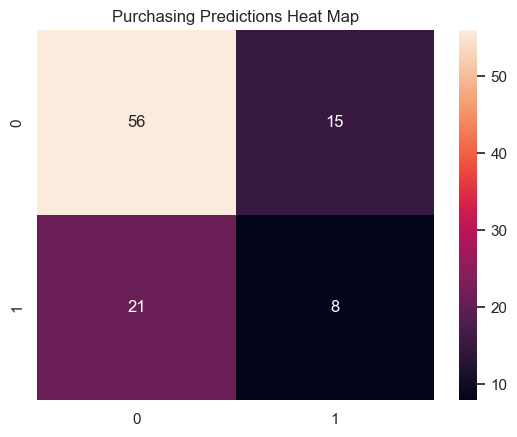

In [155]:
#Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true = y_test,
                       y_pred = predictions))
sns.heatmap(confusion_matrix(y_test,predictions), annot = True).set_title("Purchasing Predictions Heat Map")

In [156]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Positives:",tp)
print("True Negatives:", tn)

True Positives: 8
True Negatives: 56


In [157]:
# Calculate the accuracy of the model on the training data and the testing data. How does the performance compare?
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.7975
0.64


In [158]:
##Optimizing the KNN model
# Make a loop to run a range of nearest neighbours to find the best model

err_rate = []
accuracy = []

# Calculate multiple models:
for i in range(1,101):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    predictions_i = knn.predict(X_test)

    # and Track the results!
    err_rate.append(np.mean(predictions_i != y_test)) # another way to calculate the error rate
    accuracy.append(knn.score(X_test, y_test))
err_rate

[np.float64(0.37),
 np.float64(0.31),
 np.float64(0.34),
 np.float64(0.32),
 np.float64(0.36),
 np.float64(0.28),
 np.float64(0.32),
 np.float64(0.3),
 np.float64(0.36),
 np.float64(0.31),
 np.float64(0.31),
 np.float64(0.34),
 np.float64(0.37),
 np.float64(0.34),
 np.float64(0.35),
 np.float64(0.33),
 np.float64(0.34),
 np.float64(0.29),
 np.float64(0.3),
 np.float64(0.28),
 np.float64(0.31),
 np.float64(0.31),
 np.float64(0.29),
 np.float64(0.3),
 np.float64(0.29),
 np.float64(0.28),
 np.float64(0.29),
 np.float64(0.3),
 np.float64(0.32),
 np.float64(0.28),
 np.float64(0.29),
 np.float64(0.27),
 np.float64(0.3),
 np.float64(0.27),
 np.float64(0.29),
 np.float64(0.29),
 np.float64(0.29),
 np.float64(0.29),
 np.float64(0.28),
 np.float64(0.29),
 np.float64(0.31),
 np.float64(0.31),
 np.float64(0.31),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.29),
 np.float64(0.28),
 np.float64(0.29),
 np.float64(0.27),
 np.float64(0.28),
 np.float64(0.29),
 np.float64(0.29),
 

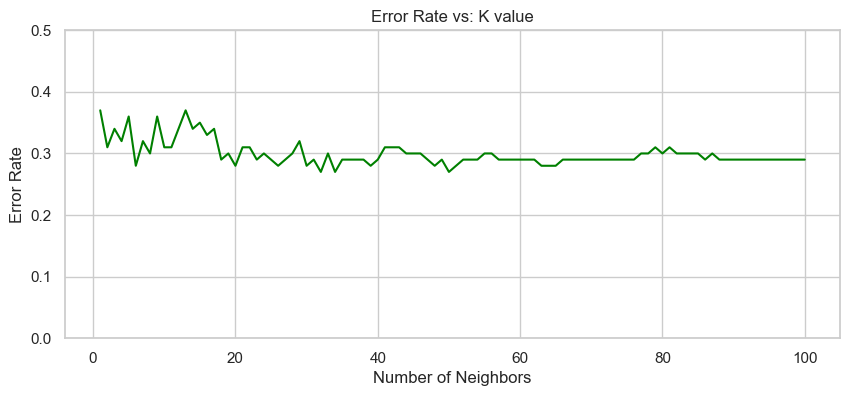

In [159]:
plt.figure(figsize = (10,4))

plt.plot(range(1,101), err_rate, color ="green" )
plt.ylim(0, 0.5)
plt.title("Error Rate vs: K value")
plt.xlabel("Number of Neighbors")
plt.ylabel("Error Rate")

plt.show()

In [160]:
min(err_rate)
best_knn = err_rate.index(min(err_rate)) + 1 
print(best_knn)

32


In [161]:
# Run the best model

best_knn_model = KNeighborsClassifier(n_neighbors = best_knn)
best_knn_model.fit(X_train, y_train)
#predictions_best = best_knn_model.predict(X_test)

print(best_knn_model.score(X_test, y_test))

0.73


In [162]:
best_knn_model = KNeighborsClassifier(n_neighbors = best_knn, metric = "cityblock")
best_knn_model.fit(X_train, y_train)
#predictions_best = best_knn_model.predict(X_test)

print(best_knn_model.score(X_test, y_test))

0.74


In [163]:
best_knn_model = KNeighborsClassifier(n_neighbors = best_knn, metric = "euclidean")
best_knn_model.fit(X_train, y_train)
#predictions_best = best_knn_model.predict(X_test)

print(best_knn_model.score(X_test, y_test))

0.73


In [164]:
best_knn_model = KNeighborsClassifier(n_neighbors = best_knn, metric = "minkowski", p=3)
best_knn_model.fit(X_train, y_train)
#predictions_best = best_knn_model.predict(X_test)

print(best_knn_model.score(X_test, y_test))

0.69


## Step 11: Try another classification model

In [165]:
    ##SVM
    from sklearn.svm import SVC
    
    # Create an instance of 'svm_model'
    model_SVM = SVC(max_iter = 1000,
                   kernel = "rbf") # max_iter is not required, but can prevent crashing when models don't converge
    model_SVM.fit(X_train, y_train) 
    
    predictions_SVM = model_SVM.predict(X_test)
    print("Model Score = ",model_SVM.score(X_test,y_test))
    ### Optimize a SVC Model using GridSearch
    param_grid = {'C': [0.1, 1, 10, 100, 1000],
                  'gamma': [1, 0.1, 0.01,0.001,0.0001]}
    # We need to import GridSearchCV from model_selection. ** Must be capitalized in GridSearchCV! **
    from sklearn.model_selection import GridSearchCV
    # refit = True by default, this re-trains the best model and saves it in 'grid' for further use. 
    SVC_grid = GridSearchCV(SVC(), param_grid, verbose=2, refit = True) 
    
    #grid is an instance of the gridsearch. 
    # Run a model and save the results for each combination of variables in the grid
    SVC_grid.fit(X_train,y_train)
    print('The best parameters are %s with a score of %0.2f' 
          % (SVC_grid.best_params_, SVC_grid.best_score_))
    #Now we have everything in grid, including the best one, so we can just use that:
    grid_SVC_predictions = SVC_grid.predict(X_test)
    
    print("Model Score = ",SVC_grid.score(X_test,y_test))

Model Score =  0.74
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................

In [166]:
## Decision tree classifier
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(criterion = "entropy", 
                                    max_leaf_nodes = 1000)
model_tree.fit(X_train, y_train)

predictions_tree = model_tree.predict(X_test)
print("Model score = ",model_tree.score(X_test,y_test))


Model score =  0.68


In [167]:
## Random forext classifier
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators = 10, # Default is 100
                                  bootstrap = True) # If false, then all features will be used in each tree ("bagging")
                                                    # class_weight allows you to add weighting ("boosting")   
model_RF.fit(X_train, y_train)

predictions_RF = model_RF.predict(X_test)
print("Model Score =",model_RF.score(X_test,y_test))


Model Score = 0.72
